In [2]:
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib as mpl
from matscipy import rings
from ase.neighborlist import neighbor_list
from collections import Counter
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from voids_strain import *
plt.style.use('~/plot.mplstyle')
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['mathtext.default']='regular'
cm=1/2.54

In [3]:
def rings_distribution(wdir, atoms, cutoff=2.85, maxlength=20):
    atoms=atoms[atoms.numbers==14]
    rings_tmp = rings.ring_statistics(atoms, cutoff, maxlength=maxlength)
    
    # Pad the array to ensure it matches the desired maximum length
    dist_tmp = np.pad(rings_tmp, (0, maxlength + 5 - len(rings_tmp)))
    
    # Extract ring counts up to `maxlength`
    rings_dist = dist_tmp[:maxlength + 1]
    rings_dist_frac = rings_dist / np.sum(rings_dist)  # Convert to percentage


    # Return results in a dictionary
    rings_length = np.arange(0, maxlength + 1)
    result = {
        'rings_length': rings_length.tolist(),
        'rings_dist': rings_dist.tolist(),
        'rings_dist_frac': rings_dist_frac.tolist()
    }
    np.save(f'{wdir}/rings.npy', result)

    return result

In [4]:
def count_sih(wdir, atoms, cutoffs = {('Si', 'Si'): 2.85,('Si', 'H'): 1.8, ('H', 'H'):1}, max_Si_coord=6):
    i, j, D = neighbor_list('ijD', atoms, cutoffs)
    count_Si = np.zeros(len(atoms), dtype=int)
    count_H  = np.zeros(len(atoms), dtype=int)

    for idx in range(len(i)):
        a = i[idx]
        b = j[idx]
        if atoms.numbers[b] == 14:
            count_Si[a] += 1
        elif atoms.numbers[b] == 1:
            count_H[a] += 1
    
    Si_coords=np.zeros(max_Si_coord)

    for i in np.arange(max_Si_coord):
        mask = (atoms.numbers == 14) & (count_H == i)
        Si_coords[i]=np.sum(np.unique(count_Si[mask], return_counts=True)[1])/len(atoms[atoms.numbers==14])
    
    mask = (atoms.numbers == 1) & (count_Si == 0)
    H2_count = np.sum(np.unique(count_H[mask], return_counts=True)[1])/len(atoms[atoms.numbers==1]) if np.any(mask) else 0
    mask = (atoms.numbers == 1) & (count_Si == 2)
    Hint_count = np.sum(np.unique(count_H[mask], return_counts=True)[1])/len(atoms[atoms.numbers==1]) if np.any(mask) else 0   
    mask = (atoms.numbers == 1) & (count_Si == 1)
    SiH_count = np.sum(np.unique(count_H[mask], return_counts=True)[1])/len(atoms[atoms.numbers==1]) if np.any(mask) else 0

    H_coords = np.array([H2_count, Hint_count, SiH_count])

    np.savetxt(f'{wdir}/Si_coordination.txt', Si_coords)
    np.savetxt(f'{wdir}/H_counts.txt', H_coords)

    return Si_coords, H_coords


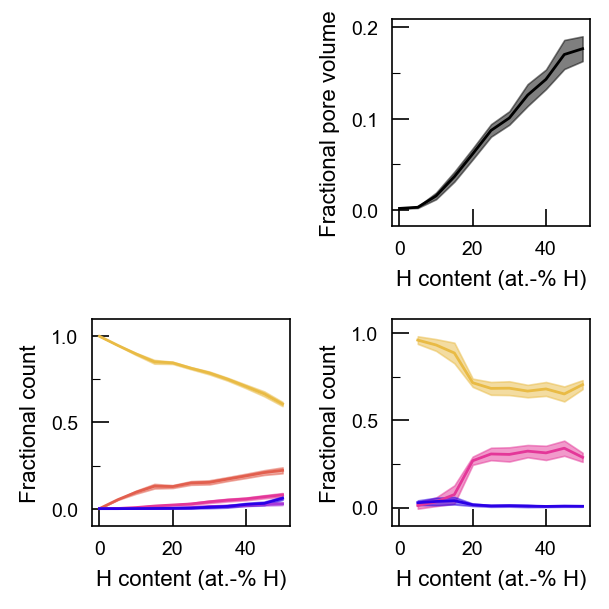

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(8*cm,8*cm))

Hconcs = np.arange(0, 55, 5)
repeats = np.arange(1, 11)
max_Si_coord = 6
Si_coord = np.zeros((len(repeats), len(Hconcs), max_Si_coord))  


n_H_types = 3   # H2, Hint, SiH
H_counts = np.zeros((len(repeats), len(Hconcs), n_H_types))

fractional_pore = np.zeros((len(repeats), len(Hconcs)))

for i, Hconc in enumerate(Hconcs):
    for repeat in repeats:
        wdir = f'../../data/paper/amorphous/Hconc-{Hconc:.0f}/{repeat}'
        atoms = read(f'{wdir}/out_anneal_SiH.data', format='lammps-data', atom_style='atomic')

        # Coordination count
        try:
            Si_coords = np.loadtxt(f'{wdir}/Si_coordination.txt')
            H_coords  = np.loadtxt(f'{wdir}/H_counts.txt')
        except:
            Si_coords, H_coords = count_sih(wdir, atoms, max_Si_coord=max_Si_coord)

        Si_coord[repeat-1, i, :] = Si_coords[:max_Si_coord]
        H_counts[repeat-1, i, :] = H_coords

        # Pores
        try:
            [radii, pore_v, cell_v]=np.loadtxt(f'{wdir}/pore_analysis.txt')

        except:
            del[atoms[atoms.numbers==1]]
            radii, cell_v, pore_v,=calc_pores(atoms, spacing=0.25, cutoff=2.5, min_points=3)
            np.savetxt(f'{wdir}/pore_analysis.txt', [radii, pore_v, cell_v])

        fractional_pore[repeat-1, i] = pore_v/cell_v


Si_coord_av = np.mean(Si_coord, axis=0)
Si_coord_std = np.std(Si_coord, axis=0)

colors_Si = ["#2a00e6","#a839d8","#e43799","#e25f4e","#e9bb45"][::-1]
for coord in range(max_Si_coord-1):
    axes[1,0].plot(Hconcs, Si_coord_av[:, coord], color=colors_Si[coord], label=f'n = {coord}')
    axes[1,0].fill_between(
        Hconcs,
        Si_coord_av[:, coord] - Si_coord_std[:, coord],
        Si_coord_av[:, coord] + Si_coord_std[:, coord],
        color=colors_Si[coord],
        alpha=0.5
    )


H_counts_av = np.mean(H_counts, axis=0)
H_counts_std = np.std(H_counts, axis=0)

colors_H = ["#e43799", "#2a00e6", "#e9bb45"]
labels_H = ["H2", "Hint", "SiH"]

for htype in range(n_H_types):
    axes[1,1].plot(Hconcs[1:], H_counts_av[1:, htype], color=colors_H[htype], label=labels_H[htype])
    axes[1,1].fill_between(
        Hconcs[1:],
        H_counts_av[1:, htype] - H_counts_std[1:, htype],
        H_counts_av[1:, htype] + H_counts_std[1:, htype],
        color=colors_H[htype],
        alpha=0.5
    )

fractional_pore_av=np.mean(fractional_pore, axis=0)
fractional_pore_std=np.std(fractional_pore, axis=0)
axes[0,1].plot(Hconcs, fractional_pore_av, color='k')
axes[0,1].fill_between(Hconcs, fractional_pore_av - fractional_pore_std, fractional_pore_av + fractional_pore_std, color='k', alpha=0.5)

axes[0,1].set_ylabel('Fractional pore volume')
axes[0,1].set_yticks(np.arange(0.05,0.25, 0.05), minor=True)
axes[0,1].set_yticks(np.arange(0,0.3, 0.1), minor=False )

axes[0,1].set_xlabel('H content (at.-% H)')
axes[0,1].set_xlim(left=-2, right=52)

axes[1,0].set_yticks(np.arange(0.25,1.25, 0.5), minor=True)
axes[1,0].set_yticks(np.arange(0,1.5, 0.5), minor=False )

axes[1,0].set_ylabel('Fractional count')
axes[1,0].set_xlabel('H content (at.-% H)')
axes[1,0].set_xlim(left=-2, right=52)
axes[1,1].set_xlim(left=-2, right=52)
axes[1,1].set_xlabel('H content (at.-% H)')
axes[1,1].set_ylabel('Fractional count')
axes[1,1].set_yticks(np.arange(0.25,1.25, 0.5), minor=True)
axes[1,1].set_yticks(np.arange(0,1.5, 0.5), minor=False )
axes[0,0].axis('off')
fig.tight_layout()

# fig.savefig('amorph-coord_v4.svg', dpi=300)
